Sample: 100%|███████████████████████████████████████| 1000/1000 [00:49, 20.17it/s, step size=2.66e-02, acc. prob=0.916]


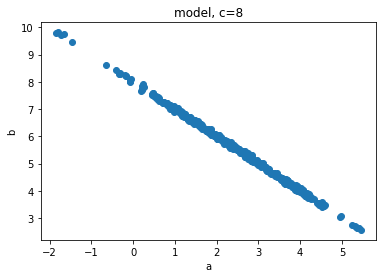

loss @ 0 26.357455134391785
loss @ 100 3.910088747739792
loss @ 200 3.2230204641819
loss @ 300 3.016251862049103
loss @ 400 2.6472308933734894
loss @ 500 3.1892621368169785
loss @ 600 2.769894599914551
loss @ 700 3.0605552345514297
loss @ 800 3.1519607305526733
loss @ 900 2.7673807591199875
loss @ 1000 3.1188551038503647
loss @ 1100 2.8389021903276443
loss @ 1200 2.643742173910141
loss @ 1300 3.010276347398758
loss @ 1400 4.4462535083293915
loss @ 1500 2.5322156101465225
loss @ 1600 3.078170031309128
loss @ 1700 2.521960571408272
loss @ 1800 3.0574318915605545
loss @ 1900 3.0893435776233673
loss @ 2000 2.7314914166927338
loss @ 2100 2.566646486520767
loss @ 2200 2.8307601660490036
loss @ 2300 3.185290217399597
loss @ 2400 3.0270616710186005
loss @ 2500 2.973217859864235
loss @ 2600 3.1459780484437943
loss @ 2700 3.3850143551826477
loss @ 2800 3.086980551481247
loss @ 2900 2.962604284286499
loss @ 3000 2.7129918187856674
loss @ 3100 3.5362210273742676
loss @ 3200 3.1335931718349457
loss

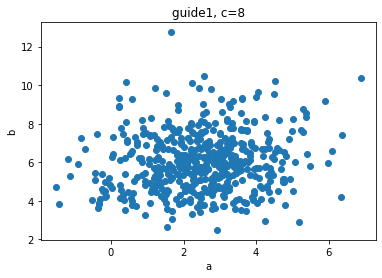

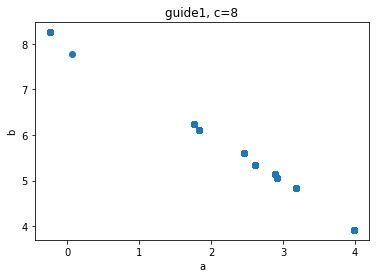

loss @ 0 4.866023063659668
loss @ 100 2.6318937242031097
loss @ 200 3.162636950612068
loss @ 300 1.159497745335102
loss @ 400 0.6395809985697269
loss @ 500 1.5388729199767113
loss @ 600 0.3806817242875695
loss @ 700 0.1933035310357809
loss @ 800 1.832689501810819
loss @ 900 0.05015918961726129
loss @ 1000 0.04671870730817318
loss @ 1100 0.9404602721333504
loss @ 1200 0.6778991615283303
loss @ 1300 0.4797091968357563
loss @ 1400 1.2284710570820607
loss @ 1500 0.608310972340405
loss @ 1600 0.08458918984979391
loss @ 1700 0.646513095125556
loss @ 1800 -0.3020854899659753
loss @ 1900 0.5366355222649872
loss @ 2000 0.30176864471286535
loss @ 2100 0.07007519993931055
loss @ 2200 0.28424027375876904
loss @ 2300 0.48610816174186766
loss @ 2400 0.6885752994567156
loss @ 2500 2.322370335459709
loss @ 2600 0.11552893370389938
loss @ 2700 -0.25062404200434685
loss @ 2800 -0.16994903981685638
loss @ 2900 0.911331438459456
loss @ 3000 0.2779858401045203
loss @ 3100 -0.0017774906009435654
loss @ 3200

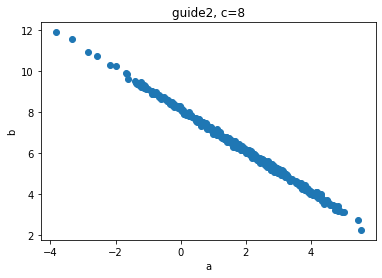

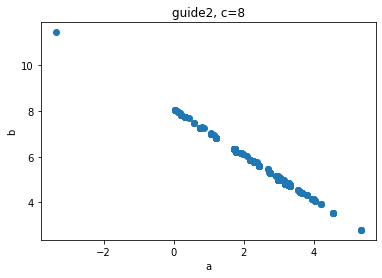

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyro
import torch
import torch.nn as nn
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
import pyro.infer
import pyro.optim
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO, MCMC, NUTS

def make_plot(x, y, main):
    plt.plot(x, y, "o")
    plt.title(main)
    plt.xlabel("a")
    plt.ylabel("b")
    plt.show()
    
class simpleNN(nn.Module):
    def __init__(self, input_size=1, hidden=32, out_size=1, t="normal", out_non_linear=None):
        super().__init__()
        self.t = t
        self.out_non_linear = out_non_linear
        self.hiddeen_layer = nn.Linear(input_size, hidden)
        if t == "normal" or t == "gamma":
            self.loc_layer = nn.Linear(hidden, out_size)
            self.std_layer = nn.Linear(hidden, out_size)
            self.softplus = nn.Softplus()
        elif t == "bern":
            self.prob_layer = nn.Linear(hidden, out_size)
        elif t == "mlp":
            self.out_layer = nn.Linear(hidden, out_size)
        
    def forward(self, x_list):
        for i in range(len(x_list)):
            if x_list[i].dim() == 0:
                x_list[i] = torch.unsqueeze(x_list[i], dim=0)
        input_x = torch.cat(x_list, 0)
        hid = F.relu(self.hiddeen_layer(input_x))
        # return loc, std
        if self.t == "normal":
            return self.loc_layer(hid), self.softplus(self.std_layer(hid))
        elif self.t == "gamma":
            return self.softplus(self.loc_layer(hid)), self.softplus(self.std_layer(hid))
        elif self.t == "bern":
            return torch.sigmoid(self.prob_layer(hid))
        else:
            if self.out_non_linear == "tanh":
                return torch.tanh(self.out_layer(hid))
            else:
                return self.out_layer(hid)
    
g1_nnb_c = simpleNN(t="gamma")
g1_nna_c = simpleNN()
g2_nnb_c = simpleNN(t="gamma")
g2_nna_c = simpleNN(input_size=2)

guide1_a = []
guide1_b = []
guide2_a = []
guide2_b = []
    
def model(observations={"c" : 0}):
    a = pyro.sample("a", dist.Normal(0, 2))
    b = pyro.sample("b", dist.Gamma(8, 2))
    c = pyro.sample("c", dist.Normal(a + b, 0.05), obs=observations["c"])
    return c
    #return {"a" : a, "b" : b, "c" : c}

def guide1(observations={"c" : 0}):
    pyro.module("g1_nnb_c", g1_nnb_c)
    pyro.module("g1_nna_c", g1_nna_c)
    c = observations["c"]
    b_alpha, b_beta = g1_nnb_c([c])
    b = pyro.sample("b", dist.Gamma(b_alpha, b_beta))
    a_mu, a_sig = g1_nna_c([c])
    a = pyro.sample("a", dist.Normal(a_mu, a_sig))
#     guide1_a.append(a.detach().numpy())
#     guide1_b.append(b.detach().numpy())
    return a.detach().numpy(), b.detach().numpy()

def guide2(observations={"c" : 0}):
    pyro.module("g2_nnb_c", g2_nnb_c)
    pyro.module("g2_nna_c", g2_nna_c)
    c = observations["c"]
    b_alpha, b_beta = g2_nnb_c([c])
    b = pyro.sample("b", dist.Gamma(b_alpha, b_beta))
    a_mu, a_sig = g2_nna_c([c, b])
    a = pyro.sample("a", dist.Normal(a_mu, a_sig))
#     guide2_a.append(a.detach().numpy())
#     guide2_b.append(b.detach().numpy())
    return a.detach().numpy(), b.detach().numpy()
    
c = torch.tensor(8.)
num_samples = 500

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=num_samples)
mcmc.run({"c": c})
model_samples = mcmc.get_samples()
model_a = model_samples["a"].detach().numpy()
model_b = model_samples["b"].detach().numpy()
make_plot(model_a, model_b, main="model, c="+str(int(c)))

def run_guide_csis(guide):
    pyro.clear_param_store()
    g1_nnb_c = simpleNN()
    g1_nna_c = simpleNN()
    g2_nnb_c = simpleNN()
    g2_nna_c = simpleNN(input_size=2)
    adam_params = {"lr": 0.005, "betas": (0.95, 0.999)}
    optimizer = Adam(adam_params)
    n_steps = 5000
    csis = pyro.infer.CSIS(model, guide, optimizer, num_inference_samples=100)

    for step in range(n_steps):
        loss = csis.step()
        if step % 100 == 0:
            print("loss @ " + str(step), loss)
    posterior = csis.run(observations={"c": c})
    marginal = pyro.infer.EmpiricalMarginal(posterior, ["a", "b"])
    csis_samples_a = []
    csis_samples_b = []
    for _ in range(num_samples):
        sample = marginal()
        a = float(sample[0])
        b = float(sample[1])
        csis_samples_a.append(a)
        csis_samples_b.append(b)
    return csis_samples_a, csis_samples_b

guide1_a_is, guide1_b_is = run_guide_csis(guide1)
for _ in range(num_samples):
    a, b =guide1({"c" : c})
    guide1_a.append(a)
    guide1_b.append(b)
make_plot(guide1_a, guide1_b, main="guide1, c="+str(int(c)))
make_plot(guide1_a_is, guide1_b_is, main="guide1, c="+str(int(c)))

guide2_a_is, guide2_b_is = run_guide_csis(guide2)
for _ in range(num_samples):
    a, b =guide2({"c" : c})
    guide2_a.append(a)
    guide2_b.append(b)
make_plot(guide2_a, guide2_b, main="guide2, c="+str(int(c)))
make_plot(guide2_a_is, guide2_b_is, main="guide2, c="+str(int(c)))

'''
def run_guide_svi(guide):
    pyro.clear_param_store()
    g1_nnb_c = simpleNN()
    g1_nna_c = simpleNN()
    g2_nnb_c = simpleNN()
    g2_nna_c = simpleNN(input_size=2)
    adam_params = {"lr": 0.005, "betas": (0.95, 0.999)}
    optimizer = Adam(adam_params)
    n_steps = 5000
    guide_a = []
    guide_b = []
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
    for step in range(n_steps):
        loss = svi.step({"c" : c})
        if step % 100 == 0:
            print("loss @ " + str(step), loss)
    for _ in range(num_samples):
        a, b =guide({"c" : c})
        guide_a.append(a)
        guide_b.append(b)
    return guide_a, guide_b
# guide1_a, guide1_b = run_guide_svi(guide1)
# make_plot(guide1_a, guide1_b, main="guide1")
# guide2_a, guide2_b = run_guide_svi(guide2)
# make_plot(guide2_a, guide2_b, main="guide2")
'''
